<a href="https://colab.research.google.com/github/vparro/MLprobabilistico/blob/master/SIRCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações básicas

In [24]:
import pylab as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from scipy.integrate import odeint
!pip install lmfit
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

# Referências

https://www.apple.com/covid19/mobility

https://painel.covid19br.org

# **Dados sobre CoVid19 Brasil**

In [25]:
# reading csv file  
BRdata = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PG_IMT/DadosEpidemia/CoVid19.csv") 
BRdata.head()


,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants
0,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
1,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
2,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
3,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
4,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN


# **Filtrando e limpando os dados interessantes**

In [26]:
is_SP =  BRdata['state']=='TOTAL'
SPdata = BRdata[is_SP]
# SPdata = SPdata.fillna(0)
SPLimpo = SPdata[SPdata.recovered.notnull()]
SPLimpo.head()

,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants
321,2020-03-23,Brazil,TOTAL,TOTAL,9,34,358,1952,34,1891,0.01618,0.92887,0.01742,8.0,15867.0,NaN,NaN
349,2020-03-24,Brazil,TOTAL,TOTAL,13,47,303,2255,46,2201,0.02237,1.07306,0.02084,20.0,17700.0,NaN,NaN
377,2020-03-25,Brazil,TOTAL,TOTAL,12,59,311,2566,57,2433,0.02808,1.22105,0.02299,27.0,27227.0,NaN,NaN
405,2020-03-26,Brazil,TOTAL,TOTAL,18,77,424,2990,77,2915,0.03664,1.42281,0.02575,42.0,48793.0,NaN,NaN
433,2020-03-27,Brazil,TOTAL,TOTAL,16,93,486,3476,92,3417,0.04425,1.65408,0.02675,42.0,50684.0,NaN,NaN


In [0]:
SPsir = SPLimpo[[ "totalCases", "deaths","recovered"]].to_numpy()
# SPsir = SPdata[[ "totalCases", "deaths","recovered"]].to_numpy()
SPsir[:,0:]
SPI = SPsir[:,0]
auxM = SPsir[:,1]
SPM = auxM
auxR = SPsir[:,2]
SPR = auxR

**Visualizando os dados**

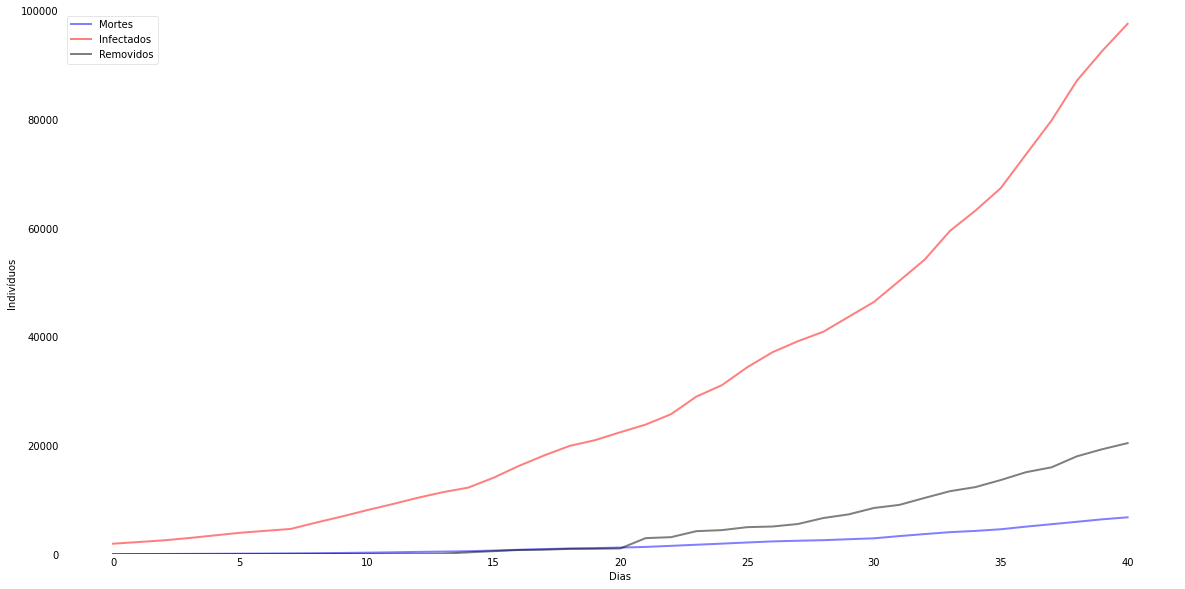

In [28]:
# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)

fig = plt.figure(facecolor='w',figsize=(20,10))

ax = fig.add_subplot(111, axisbelow=True)
ax.plot(SPM, 'b', alpha=0.5, lw=2, label='Mortes')
ax.plot(SPI, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(SPR, 'k', alpha=0.5, lw=2, label='Removidos')
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.set_ylim(0,100000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.show()

# **O problema**









O conjunto de equações diferenciais que caracteriza o modelo é descrito abaixo. No modelo $\beta - \text{representa a taxa de transmissão ou taxa efetiva de contato} $  e $r - \text{a taxa de remoção ou recuperação.}$ 


$$ \begin{split}
   \frac{dS(t)}{dt} & = -\beta S(t) I(t) \\
   \frac{dI(t)}{dt} & = \beta S(t) I(t) - rI(t)  \\
   \frac{dR(t)}{dt} & = r I(t)
   \end{split}$$

   Gostaríamos de identificar quais parâmetros $\beta$ e $r$ resultam num melhor ajuste do modelo para os dados de **S**,**I** e **R**

In [0]:
# Tamanho da população - N

N = 220e6

###############################################################################

def SIRmodel(y, t, paras):
    """
    Sistema de equações diferenciais
    """
    S = y[0]
    I = y[1]
    R = y[2]

    try:
        Beta = paras['Beta'].value
        r = paras['r'].value

    except KeyError:
        Beta, r = paras

    # Equações

    Sdot = -(Beta * S * I)
    Idot = (Beta * S * I)  - r * I
    Rdot = r * I
    return [Sdot, Idot, Rdot]

# **Obtendo**  𝑦𝑠(𝜃,𝑘)=[𝑆𝐼𝑅] 



O trecho a seguir retorna os valores sintetizados  𝑦𝑠(𝜃,𝑘)=[𝑆𝐼𝑅]  representa o dado sintetizado a partir de um modelo sintetizado para uma determinada amostra  𝑘  e  𝜃  representa o vetor ed parâmetros  𝜃=[𝛽𝑟]𝑇 . A partir de uma condição inicial  𝑦0 .

In [0]:
###############################################################################

def SIRsolve(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(SIRmodel, x0, t, args=(paras,))
    return x

# **Estimativa de parâmetros**

Para estimarmos os parâmetros do modelo $\mathbf{\beta}$ e $\mathbf{r}$, vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de $beta$ e $r$ que minizam o erro quadrático quando comparados com os dados reais.

In [0]:
###############################################################################

def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value
    model = SIRsolve(t, x0, paras)

    # you only have data for one of your variables
    x2_model = np.concatenate([model[:, 1],model[:, 2]])
    return (x2_model - data).ravel()

# **Condições inicias** -  𝑦0  e  𝜃0 

In [0]:
# initial conditions
x10 = S0
x20 = I0
x30 = R0
y0 = [x10, x20, x30]

# measured data
t_measured = np.linspace(0, len(SPsir), len(SPsir))
x2_measured = np.concatenate([Id,Rd])

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('Beta', value=1e-8, min=1e-10, max=1e-3)
params.add('r', value=5e-2, min=0.0001, max=0.2)

# **Minimização da função custo**

In [0]:
# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder

# **Visualização do ajuste**

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 82
    # variables        = 2
    chi-square         = 1.4655e+09
    reduced chi-square = 18318288.1
    Akaike info crit   = 1373.29486
    Bayesian info crit = 1378.10830
[[Variables]]
    x10:   2.19998e+08 (fixed)
    x20:   1952 (fixed)
    x30:   8 (fixed)
    Beta:  5.6980e-10 +/- 7.6828e-12 (1.35%) (init = 1e-08)
    r:     0.02692136 +/- 0.00171876 (6.38%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Beta, r) =  0.965


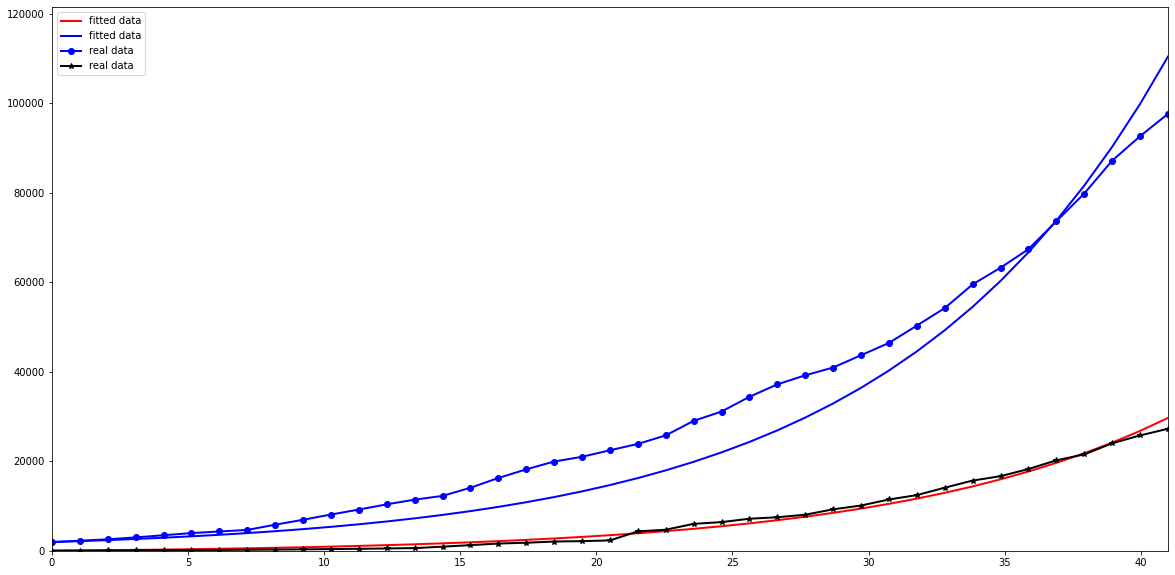

In [34]:
# check results of the fit
data_fitted = SIRsolve(t_measured, y0, result.params)

# plot fitted data
fig = plt.figure(facecolor='w',figsize=(20,10))
plt.plot(t_measured, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
plt.plot(t_measured, data_fitted[:, 1], '-', linewidth=2, color='blue', label='fitted data')
plt.plot(t_measured, Id, '-', linewidth=2, color='blue', label='real data',  marker='o')
plt.plot(t_measured, Rd, '-', linewidth=2, color='black', label='real data', marker='*')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

plt.show()

# **Predição utilizando o modelo**

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 82
    # variables        = 2
    chi-square         = 1.4655e+09
    reduced chi-square = 18318288.1
    Akaike info crit   = 1373.29486
    Bayesian info crit = 1378.10830
[[Variables]]
    x10:   2.19998e+08 (fixed)
    x20:   1952 (fixed)
    x30:   8 (fixed)
    Beta:  5.6980e-10 +/- 7.6828e-12 (1.35%) (init = 1e-08)
    r:     0.02692136 +/- 0.00171876 (6.38%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Beta, r) =  0.965


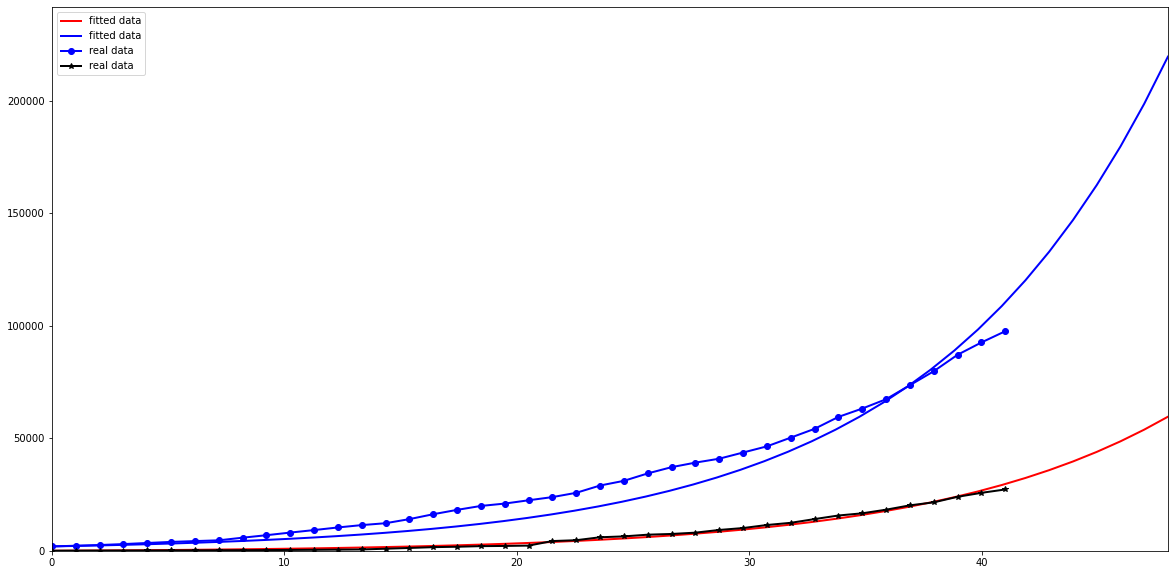

In [36]:
t_predict = np.linspace(0, len(SPsir)+7, len(SPsir)+7)

# check results of the fit
data_fitted = SIRsolve(t_sim, y0, result.params)

# plot fitted data
fig = plt.figure(facecolor='w',figsize=(20,10))
plt.plot(t_sim, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
plt.plot(t_sim, data_fitted[:, 1], '-', linewidth=2, color='blue', label='fitted data')
plt.plot(t_measured, Id, '-', linewidth=2, color='blue', label='real data',  marker='o')
plt.plot(t_measured, Rd, '-', linewidth=2, color='black', label='real data', marker='*')
plt.legend()
plt.xlim([0, max(t_sim)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

plt.show()